# Train Models

**functions imported from utils.utils**

This notebook contains the code needed to train and store models to the disk.

Functions with a random state must be fixed to a number so that the results are reproducible.

## Imports

In [25]:
# cython import
!python skseq/setup.py build_ext --build-lib=./skseq

running build_ext


In [26]:
# livelossplot installation
#!pip install livelossplot

In [27]:
from utils.utils import *

In [28]:
import pickle
import pandas as pd
import tensorflow as tf
from skseq.id_feature import IDFeatures
from skseq import structured_perceptron_c 
from skseq.extended_feature import ExtendedFeatures
from livelossplot.tf_keras import PlotLossesCallback
from skseq.structured_perceptron import StructuredPerceptron
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train Dataset

In [30]:
train = pd.read_csv("data/train_data_ner.csv")

In [31]:
X_train, y_train = get_data_target_sets(train)

Processing: 100%|████████████████████████████████████████████████████████| 38366/38366 [00:37<00:00, 1029.61sentence/s]


### Corpus Creation

We now create our corpus using the training data. The corpus consists of two dictionaries, one for the words and one for the tags. The words dictionary maps each word to an index, and the tags dictionary maps each tag to an index. We also create the reverse mapping for the tags dictionary. This is needed to convert the predictions back to the tag names.

Example:
```python
        sentences = [['I', 'love', 'Python'], ['Python', 'is', 'great']]
        tags = ['O', 'O', 'B']
        word_dict, tag_dict, tag_dict_rev = create_corpus(sentences, tags)
        # word_dict: {'I': 0, 'love': 1, 'Python': 2, 'is': 3, 'great': 4}
        # tag_dict: {'O': 0, 'B': 1}
        # tag_dict_rev: {0: 'O', 1: 'B'}
```

In [32]:
word_dict, tag_dict, tag_dict_rev = create_corpus(X_train, y_train)

### Training Sequence List

#### Without Cython

In [33]:
train_seq = create_sequence_list(word_dict, tag_dict, X_train, y_train)

Adding sequences: 100%|████████████████████████████████████████████████████| 38366/38366 [08:41<00:00, 73.51sequence/s]


#### With Cython

In [34]:
train_seq = create_sequence_listC(word_dict, tag_dict, X_train, y_train)

Adding sequences: 100%|████████████████████████████████████████████████████| 38366/38366 [08:37<00:00, 74.20sequence/s]


In [35]:
print(train_seq[0])
print(train_seq[0].to_words(sequence_list=train_seq))

0/0 1/0 2/0 3/0 4/0 5/0 6/1 7/0 8/0 9/0 10/0 11/0 12/1 13/0 14/0 9/0 15/0 1/0 16/2 17/0 18/0 19/0 20/0 21/0 
Thousands/O of/O demonstrators/O have/O marched/O through/O London/B-geo to/O protest/O the/O war/O in/O Iraq/B-geo and/O demand/O the/O withdrawal/O of/O British/B-gpe troops/O from/O that/O country/O ./O 


## Training Models

## Structured Perceptron with Default Features

To train the structured perceptron, we create and build a feature mapper.

In [36]:
feature_mapper = IDFeatures(train_seq)
feature_mapper.build_features()

In [37]:
show_features(feature_mapper, train_seq[0])

Initial features
[0] init_tag:O


Transition features
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[9] prev_tag:O::B-geo
[11] prev_tag:B-geo::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[9] prev_tag:O::B-geo
[11] prev_tag:B-geo::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[21] prev_tag:O::B-gpe
[23] prev_tag:B-gpe::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O
[3] prev_tag:O::O


Final features
[28] final_prev_tag:O


Emission features
[1] id:Thousands::O
[2] id:of::O
[4] id:demonstrators::O
[5] id:have::O
[6] id:marched::O
[7] id:through::O
[8] id:London::B-geo
[10] id:to::O
[12] id:protest::O
[13] id:the::O
[14] id:war::O
[15] id:in::O
[16] id:Iraq::B-geo
[17] id:and::O
[18] id:demand::O
[13] id:the::O
[19] id:withdrawal::O
[2] id:of::O
[20] id:British::B-gpe
[22] id:troops::O
[24] id:from::O
[25] id:that::O
[26] id:country::O
[27] id:.::O




### Training

#### Without Cython

In [38]:
num_epochs = 15
sp = StructuredPerceptron(word_dict, tag_dict, feature_mapper)
sp.num_epochs = 5

In [39]:
%%time
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.893815
Epoch: 1 Accuracy: 0.931674
Epoch: 2 Accuracy: 0.940913
Epoch: 3 Accuracy: 0.946175
Epoch: 4 Accuracy: 0.950018
Epoch: 5 Accuracy: 0.952577
Epoch: 6 Accuracy: 0.954425
Epoch: 7 Accuracy: 0.956033
Epoch: 8 Accuracy: 0.957185
Epoch: 9 Accuracy: 0.958481
Epoch: 10 Accuracy: 0.959217
Epoch: 11 Accuracy: 0.960524
Epoch: 12 Accuracy: 0.961121
Epoch: 13 Accuracy: 0.961207
Epoch: 14 Accuracy: 0.961983
CPU times: total: 1h 1min 50s
Wall time: 1h 1min 59s


In [40]:
sp.save_model("fitted_models/01_SP_Default_Features")

#### With Cython

In [41]:
num_epochs = 15
sp_c = structured_perceptron_c.StructuredPerceptronC(word_dict, tag_dict, feature_mapper)
sp_c.num_epochs = 5

In [42]:
%%time
sp_c.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.893815
Epoch: 1 Accuracy: 0.931674
Epoch: 2 Accuracy: 0.940913
Epoch: 3 Accuracy: 0.946175
Epoch: 4 Accuracy: 0.950018
Epoch: 5 Accuracy: 0.952577
Epoch: 6 Accuracy: 0.954425
Epoch: 7 Accuracy: 0.956033
Epoch: 8 Accuracy: 0.957185
Epoch: 9 Accuracy: 0.958481
Epoch: 10 Accuracy: 0.959217
Epoch: 11 Accuracy: 0.960524
Epoch: 12 Accuracy: 0.961121
Epoch: 13 Accuracy: 0.961207
Epoch: 14 Accuracy: 0.961983
CPU times: total: 1h 1min 26s
Wall time: 1h 1min 35s


In [43]:
sp_c.save_model("fitted_models/01C_SP_Default_Features")

## Structured Perceptron with New Features

In [44]:
feature_mapper_ext = ExtendedFeatures(train_seq)
feature_mapper_ext.build_features()

In [45]:
show_features(feature_mapper_ext, train_seq[1])

Initial features
[0] init_tag:O


Transition features
[8] prev_tag:O::O
[45] prev_tag:O::B-tim
[47] prev_tag:B-tim::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[16] prev_tag:O::B-geo
[18] prev_tag:B-geo::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[59] prev_tag:O::B-org
[61] prev_tag:B-org::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[8] prev_tag:O::O
[16] prev_tag:O::B-geo
[77] prev_tag:B-geo::I-geo
[78] prev_tag:I-geo::O


Final features
[38] final_prev_tag:O


Emission features
[39, 2, 3] id:Helicopter::O
[39, 2, 3] firstupper::O
[39, 2, 3] alphanum::O
[40, 5, 3] id:gunships::O
[40, 5, 3] lower::O
[40, 5, 3] alphanum::O
[41, 42, 43, 44, 44] id:Saturday::B-tim
[41, 42, 43, 44, 44] firstupper::B-tim
[41, 42, 43, 44, 44] alphanum::B-tim
[41, 42, 43, 44, 44

### Train

#### Without Cython

In [46]:
num_epochs = 15
sp_ext = StructuredPerceptron(word_dict, tag_dict, feature_mapper_ext)
sp_ext.num_epochs = 5

In [47]:
%%time
sp_ext.fit(feature_mapper_ext.dataset, num_epochs)

Epoch: 0 Accuracy: 0.930211
Epoch: 1 Accuracy: 0.944578
Epoch: 2 Accuracy: 0.948914
Epoch: 3 Accuracy: 0.951235
Epoch: 4 Accuracy: 0.953141
Epoch: 5 Accuracy: 0.954629
Epoch: 6 Accuracy: 0.955740
Epoch: 7 Accuracy: 0.956660
Epoch: 8 Accuracy: 0.957537
Epoch: 9 Accuracy: 0.958633
Epoch: 10 Accuracy: 0.959028
Epoch: 11 Accuracy: 0.959821
Epoch: 12 Accuracy: 0.959777
Epoch: 13 Accuracy: 0.961037
Epoch: 14 Accuracy: 0.960599
CPU times: total: 1h 3min 18s
Wall time: 1h 3min 33s


In [48]:
sp_ext.save_model("fitted_models/02_SP_Extended_Features")

#### With Cython

In [49]:
num_epochs = 15
sp_ext_c = structured_perceptron_c.StructuredPerceptronC(word_dict, tag_dict, feature_mapper_ext)
sp_ext_c.num_epochs = 5

In [50]:
%%time
sp_ext_c.fit(feature_mapper_ext.dataset, num_epochs)

Epoch: 0 Accuracy: 0.930211
Epoch: 1 Accuracy: 0.944578
Epoch: 2 Accuracy: 0.948914
Epoch: 3 Accuracy: 0.951235
Epoch: 4 Accuracy: 0.953141
Epoch: 5 Accuracy: 0.954629
Epoch: 6 Accuracy: 0.955740
Epoch: 7 Accuracy: 0.956660
Epoch: 8 Accuracy: 0.957537
Epoch: 9 Accuracy: 0.958633
Epoch: 10 Accuracy: 0.959028
Epoch: 11 Accuracy: 0.959821
Epoch: 12 Accuracy: 0.959777
Epoch: 13 Accuracy: 0.961037
Epoch: 14 Accuracy: 0.960599
CPU times: total: 1h 2min 50s
Wall time: 1h 3min 4s


In [51]:
sp_ext_c.save_model("fitted_models/02C_SP_Extended_Features")

## Deep Learning Approach: Bi-LSTM

### Download Data

In [52]:
train = pd.read_csv("data/train_data_ner.csv")
test = pd.read_csv("data/test_data_ner.csv")

### Preprocess Data

In [56]:
sentences_train, tags_train, num_words, num_tags, word2idx, tag2idx = preprocess_BiLSTM_train_data(train)

In [57]:
sentences_test, tags_test = preprocess_BiLSTM_test_data(test, word2idx, tag2idx,num_words)

### Create and Train Model

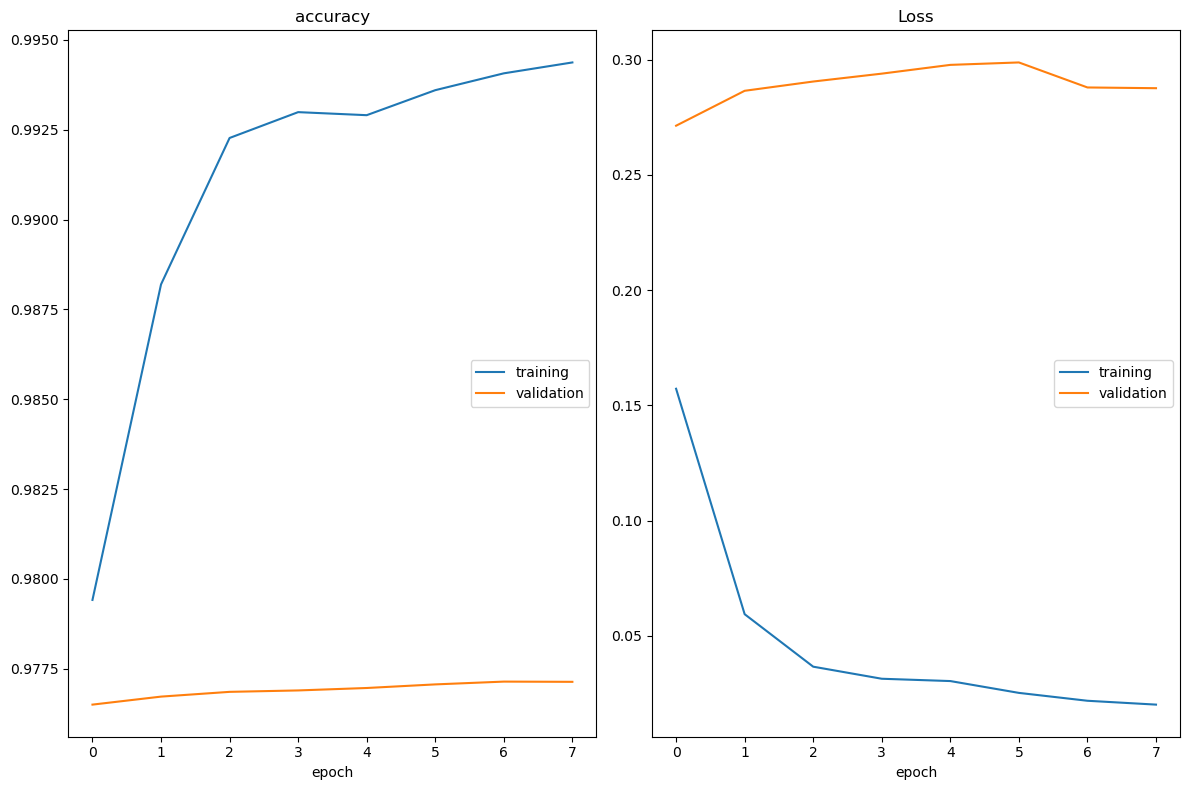

accuracy
	training         	 (min:    0.979, max:    0.994, cur:    0.994)
	validation       	 (min:    0.977, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.020, max:    0.157, cur:    0.020)
	validation       	 (min:    0.271, max:    0.299, cur:    0.288)

Epoch 8: val_loss did not improve from 0.27132
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 275s 230ms/step - accuracy: 0.9945 - loss: 0.0196 - val_accuracy: 0.9771 - val_loss: 0.2876


In [60]:
logdir = "log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# ModelCheckpoint callback to save the best model weights
chkpt = ModelCheckpoint("model.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# EarlyStopping callback to stop training early if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

# define a list of callbacks to be used during training
callbacks = [PlotLossesCallback(), chkpt, early_stopping, tensorboard_callback]

# create the BiLSTM model
model = create_BiLSTM_model(num_words)

# train the model
history = model.fit(
    x=sentences_train,
    y=tags_train,
    validation_data=(sentences_test, tags_test),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# load the TensorBoard extension
%load_ext tensorboard

# launch TensorBoard to visualize the logs
%tensorboard --logdir log

In [61]:
model.save("fitted_models/03_BiLSTM.keras")